In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from sklearn.model_selection import StratifiedKFold
from torchvision import models
from transformers import Dinov2Model

device = torch.device('cuda')

from src.train_functions import train_epoch, validate_epoch
from src.preprocess_data import data_preprocess, BiomassDS, create_strata
from src.models import get_dino
from src.transforms_functions import identity_transform, random_flip_transform, tta_transforms


In [12]:
# project_dir     = '/Users/k.choi/Documents/github/csiro_git'
# project_dir     = '/Users/kaheichoi/git_repo/csiro_biomass'
project_dir     = os.getcwd()
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()
primary_target  = ['Dry_Green_g','Dry_Total_g','GDM_g']

In [13]:
n_folds  = 5
data = data_preprocess(csv_data, data_dir)
train_data, test_data = train_test_split(data, test_size=0.05, random_state=8964)
# train_data, valid_data  = train_test_split(data, test_size=0.2, random_state=8964)

print(f"train data: {len(train_data)}")
# print(f"valid data: {len(valid_data)}")
print(f"test data: {len(test_data)}")

kfolds  = create_strata(train_data, target_col='Dry_Total_g', bins = [0, 20, 40, 60, 80, np.inf], n_folds=n_folds)

train data: 339
test data: 18


In [14]:
"""Select dinov2 model"""
dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-small'); patch_dim = 384; model_name = 'dinov2_small'
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-base'); patch_dim = 768; model_name = 'dinov2_base'
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-large'); patch_dim = 1024; model_name = 'dinov2_large'

dinov2.eval(); dinov2.to(device);

# all_params = sum(p.numel() for p in model.parameters()); print(f"Total parameters: {all_params}")
# train_params = sum(p.numel() for p in model.heads.parameters());print(f"Trainable parameters: {train_params}")
# frozen_params = sum(p.numel() for p in model.backbone.parameters());print(f"Frozen parameters: {frozen_params}")

In [16]:
""" PARAMETERS """

NUM_EPOCHS = 100
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
BATCH_SIZE = 16 
WORKERS = 2

WEIGHT_DECAY = 1e-4 
EARLY_STOPPING_PATIENCE = 10
LR = 1e-3 
LR_PATIENCE = 5
LR_FACTOR = 0.5

""" MEAN SQUARE ERROR LOSS """
criterion = nn.MSELoss()

""" TRANSFORMS """
train_transform = random_flip_transform(mean, std)
valid_transform = identity_transform(mean, std)

fold_model, fold_history, fold_best_rmses = [], [], []

for fold_idx, (train_idx, val_idx) in enumerate(kfolds):
    best_epoch, epoch_counts, best_val, best_model = 0, 0, float('inf'), None
    
    model = get_dino(dinov2, patch_dim=patch_dim, num_targets=3); model.to(device) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience= LR_PATIENCE)

    train_fold = train_data.iloc[train_idx]
    valid_fold = train_data.iloc[val_idx]

    train_ds     = BiomassDS(df =train_fold, data_dir =data_dir, transform = train_transform, target_names=primary_target)
    valid_ds     = BiomassDS(df =valid_fold, data_dir =data_dir, transform = valid_transform, target_names=primary_target)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True  , pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False , pin_memory=True)
 

    history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
    for epoch in range(NUM_EPOCHS):
        print(f"\nFold: {fold_idx}: Epoch {epoch}/{NUM_EPOCHS}"); print(32 * " -")
        train_loss                              = train_epoch(model, train_loader, optimizer, criterion, device)
        valid_loss, rmse, all_preds, all_targs  = validate_epoch(model, valid_loader, criterion, device)

        scheduler.step(valid_loss)
        current_lr = optimizer.param_groups[0]['lr']

        per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
        
        """ update history """
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['val_rmse'].append(rmse)
        history['learning_rate'].append(current_lr)
        history['pre_target_rmse'].append(per_target_rmse) 

        if epoch % 10 == 0:
            print(f"  train loss: {train_loss:.1f}")
            print(f"  valid loss: {valid_loss:.1f}")
            print(f"  rmse: {rmse:.1f}") 
            print(f"  lr: {current_lr:.6f}")
            print(f"  per target rmse: {per_target_rmse}")
        if valid_loss < best_val:
            print(f"val_loss improved from {best_val:.4f} to {valid_loss:.4f} at epoch {epoch+1} since epoch {best_epoch+1}")
            best_val, best_epoch, epoch_counter, best_model = valid_loss, epoch, 0, model.state_dict()  
            torch.save(best_model, os.path.join(model_dir, f'best_model_{model_name}_fold{fold_idx}.pth'))
        else: epoch_counter += 1;
        if epoch_counter >= EARLY_STOPPING_PATIENCE: print(f"Early stopping at epoch {epoch+1}"); break

    fold_model.append(model)
    fold_history.append(history)
    fold_best_rmses.append(best_val)


    print(f"Fold {fold_idx} completed"); print(32 * " -")


Fold: 0: Epoch 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s, loss=1.79e+3]


  train loss: 1799.3
  valid loss: 1403.7
  rmse: 36.5
  lr: 0.001000
  per target rmse: [27.901543 45.19665  34.414566]
val_loss improved from inf to 1403.6550 at epoch 1 since epoch 1

Fold: 0: Epoch 1/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s, loss=1.64e+3]


val_loss improved from 1403.6550 to 1265.0869 at epoch 2 since epoch 1

Fold: 0: Epoch 2/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s, loss=1.5e+3] 


val_loss improved from 1265.0869 to 1131.3467 at epoch 3 since epoch 2

Fold: 0: Epoch 3/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, loss=1.36e+3]


val_loss improved from 1131.3467 to 1003.6218 at epoch 4 since epoch 3

Fold: 0: Epoch 4/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.24e+3]


val_loss improved from 1003.6218 to 895.8191 at epoch 5 since epoch 4

Fold: 0: Epoch 5/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, loss=1.14e+3]


val_loss improved from 895.8191 to 802.3299 at epoch 6 since epoch 5

Fold: 0: Epoch 6/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, loss=1.05e+3]


val_loss improved from 802.3299 to 725.4190 at epoch 7 since epoch 6

Fold: 0: Epoch 7/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s, loss=972]


val_loss improved from 725.4190 to 657.9552 at epoch 8 since epoch 7

Fold: 0: Epoch 8/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s, loss=897]


val_loss improved from 657.9552 to 591.2162 at epoch 9 since epoch 8

Fold: 0: Epoch 9/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=791]


val_loss improved from 591.2162 to 532.4108 at epoch 10 since epoch 9

Fold: 0: Epoch 10/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s, loss=716]


  train loss: 702.8
  valid loss: 483.2
  rmse: 21.0
  lr: 0.001000
  per target rmse: [15.302074 26.536499 19.704481]
val_loss improved from 532.4108 to 483.2149 at epoch 11 since epoch 10

Fold: 0: Epoch 11/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s, loss=662]


val_loss improved from 483.2149 to 443.1829 at epoch 12 since epoch 11

Fold: 0: Epoch 12/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, loss=613]


val_loss improved from 443.1829 to 405.9259 at epoch 13 since epoch 12

Fold: 0: Epoch 13/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s, loss=567]


val_loss improved from 405.9259 to 376.3228 at epoch 14 since epoch 13

Fold: 0: Epoch 14/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=530]


val_loss improved from 376.3228 to 343.7042 at epoch 15 since epoch 14

Fold: 0: Epoch 15/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s, loss=510]


val_loss improved from 343.7042 to 333.3284 at epoch 16 since epoch 15

Fold: 0: Epoch 16/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, loss=453]


val_loss improved from 333.3284 to 297.8895 at epoch 17 since epoch 16

Fold: 0: Epoch 17/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s, loss=432]


val_loss improved from 297.8895 to 292.7133 at epoch 18 since epoch 17

Fold: 0: Epoch 18/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=379]


val_loss improved from 292.7133 to 252.4230 at epoch 19 since epoch 18

Fold: 0: Epoch 19/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s, loss=372]



Fold: 0: Epoch 20/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, loss=317]


  train loss: 347.2
  valid loss: 237.9
  rmse: 15.0
  lr: 0.001000
  per target rmse: [11.272859 18.473742 14.266665]
val_loss improved from 252.4230 to 237.9400 at epoch 21 since epoch 19

Fold: 0: Epoch 21/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=326]


val_loss improved from 237.9400 to 218.5854 at epoch 22 since epoch 21

Fold: 0: Epoch 22/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s, loss=324]



Fold: 0: Epoch 23/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=323] 


val_loss improved from 218.5854 to 218.1762 at epoch 24 since epoch 22

Fold: 0: Epoch 24/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, loss=289]


val_loss improved from 218.1762 to 215.5463 at epoch 25 since epoch 24

Fold: 0: Epoch 25/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s, loss=283]


val_loss improved from 215.5463 to 199.1114 at epoch 26 since epoch 25

Fold: 0: Epoch 26/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=255] 


val_loss improved from 199.1114 to 193.1572 at epoch 27 since epoch 26

Fold: 0: Epoch 27/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s, loss=242]


val_loss improved from 193.1572 to 192.9885 at epoch 28 since epoch 27

Fold: 0: Epoch 28/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=280] 



Fold: 0: Epoch 29/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, loss=244]


val_loss improved from 192.9885 to 190.5503 at epoch 30 since epoch 28

Fold: 0: Epoch 30/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s, loss=225]


  train loss: 198.3
  valid loss: 185.1
  rmse: 13.3
  lr: 0.001000
  per target rmse: [ 9.692646 16.777605 12.595304]
val_loss improved from 190.5503 to 185.0602 at epoch 31 since epoch 30

Fold: 0: Epoch 31/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s, loss=206]



Fold: 0: Epoch 32/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s, loss=221]



Fold: 0: Epoch 33/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, loss=263]



Fold: 0: Epoch 34/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s, loss=312]



Fold: 0: Epoch 35/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s, loss=219]


val_loss improved from 185.0602 to 170.9735 at epoch 36 since epoch 31

Fold: 0: Epoch 36/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s, loss=213]



Fold: 0: Epoch 37/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s, loss=269]



Fold: 0: Epoch 38/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s, loss=240]



Fold: 0: Epoch 39/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, loss=161]



Fold: 0: Epoch 40/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s, loss=169]


  train loss: 138.2
  valid loss: 194.0
  rmse: 14.1
  lr: 0.001000
  per target rmse: [11.20077  17.023575 13.416015]

Fold: 0: Epoch 41/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s, loss=223]



Fold: 0: Epoch 42/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, loss=212]



Fold: 0: Epoch 43/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s, loss=250]



Fold: 0: Epoch 44/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s, loss=204]



Fold: 0: Epoch 45/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s, loss=280] 


Early stopping at epoch 46
Fold 1 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Fold: 1: Epoch 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s, loss=4.03e+3]


  train loss: 1765.4
  valid loss: 1845.0
  rmse: 38.2
  lr: 0.001000
  per target rmse: [32.201313 45.692986 35.382328]
Early stopping at epoch 1
Fold 2 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Fold: 2: Epoch 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s, loss=3.42e+3]


  train loss: 1731.4
  valid loss: 1906.9
  rmse: 40.5
  lr: 0.001000
  per target rmse: [34.1738   47.4269   38.735107]
Early stopping at epoch 1
Fold 3 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Fold: 3: Epoch 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, loss=395]    


  train loss: 1650.1
  valid loss: 1811.3
  rmse: 45.4
  lr: 0.001000
  per target rmse: [40.313923 52.119736 42.919567]
Early stopping at epoch 1
Fold 4 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Fold: 4: Epoch 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s, loss=1.21e+3]

  train loss: 1724.8
  valid loss: 1574.6
  rmse: 40.6
  lr: 0.001000
  per target rmse: [34.63699  48.229942 37.56657 ]
Early stopping at epoch 1
Fold 5 completed
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


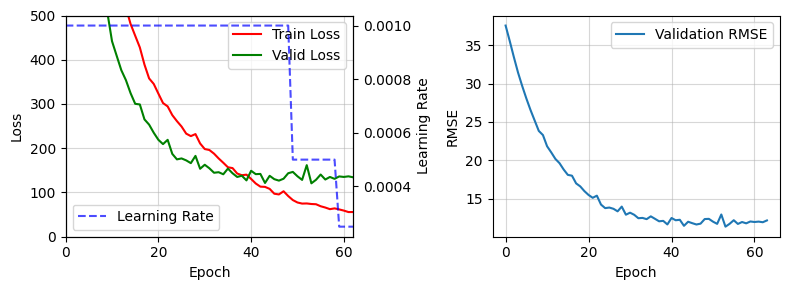

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()
ax1 = axes[0].twinx()
Reds = sns.color_palette("Reds", as_cmap=True)
Greens = sns.color_palette("Greens", as_cmap=True)
Blues = sns.color_palette("Blues", as_cmap=True)

crange = np.linspace(0, 1, n_folds)


for histories in fold_history: 

    if fold_idx == 0:
        axes[0].plot(histories['train_loss'], label='Train Loss', c=Reds(crange[fold_idx]))
        axes[0].plot(histories['valid_loss'], label='Valid Loss', c=Greens(crange[fold_idx]))
        ax1.plot(histories['learning_rate'], label='Learning Rate', c=Blues(crange[fold_idx]), ls='--', alpha=0.7)
        axes[1].plot(histories['val_rmse'], label='Validation RMSE', c=Greens(crange[fold_idx]))
    else :
        axes[0].plot(histories['train_loss'], c=Reds(crange[fold_idx]))
        axes[0].plot(histories['valid_loss'], c=Greens(crange[fold_idx]))
        ax1.plot(histories['learning_rate'], c=Blues(crange[fold_idx]), ls='--', alpha=0.7)
        axes[1].plot(histories['val_rmse'], c=Greens(crange[fold_idx]))
    
axes[0].set_xlim(0, 62)
axes[0].set_ylim(0, 500)

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('RMSE')
ax1.set_ylabel('Learning Rate')
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')
ax1.set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)
ax1.legend(loc='lower left')
axes[0].legend(loc = 'upper right')
axes[1].legend(loc='upper right')
ax1.legend(loc='lower left')
plt.tight_layout()
plt.show()


In [ ]:
data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [ ]:
for histories in fold_history:
    history_pd = pd.DataFrame(histories)
    history_pd.to_csv(os.path.join(model_dir, f'history_{model_name}_fold_{fold_idx}.csv'), index=False)        

In [ ]:
def eval_testds(model, loader, device):  

    pred_list , targ_list = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Testing')
        for img, tar in pbar:
            img = img.to(device); tar = tar.to(device)
            pred = model(img);
            pred_list.append(pred.cpu())
            targ_list.append(tar.cpu())
        pred_list = torch.cat(pred_list, dim=0).numpy()
        targ_list = torch.cat(targ_list, dim=0).numpy()
    return pred_list, targ_list


test_ds     = BiomassDS(df =test_data, data_dir =data_dir, transform = valid_transform, target_names=primary_target)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=False , pin_memory=False)

fold_preds = []
targ_lists = []

for fold_idx in range(n_folds):
    model.load_state_dict(torch.load(os.path.join(model_dir, f'best_model_{model_name}_fold{fold_idx}.pth')))
    model.eval();

    pred_list, targ_list = eval_testds(model, test_loader, device)
    fold_preds.append(pred_list)

Testing: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

metric_data = []

for i , tar in enumerate(primary_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metric_data.append({ 'target': tar, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2})

metric_data.append({
    'target' : 'overall', 
    'mae': mean_absolute_error(targ_list.flatten(), pred_list.flatten()), 
    'mse': mean_squared_error(targ_list.flatten(), pred_list.flatten()), 
    'rmse': np.sqrt(mean_squared_error(targ_list.flatten(), pred_list.flatten())), 
    'r2': r2_score(targ_list.flatten(), pred_list.flatten())})

metric_df = pd.DataFrame(metric_data)
display(metric_df)
metric_df.to_csv(os.path.join(model_dir, f'metric_{model_name}.csv'), index=False)

,target,mae,mse,rmse,r2
0,Dry_Green_g,6.741815,79.799385,8.933050,0.827332
1,Dry_Total_g,10.683629,228.296875,15.109496,0.675391
2,GDM_g,6.932826,77.277466,8.790760,0.824861
3,overall,8.119423,128.457901,11.333927,0.788561


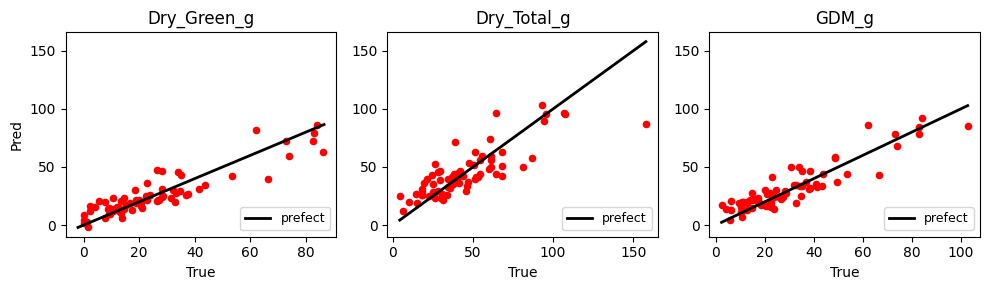

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i , tar in enumerate(primary_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[i].scatter(y_true, y_pred, alpha=1, c='r', s= 20)
    if i>0: axes[i].sharey(axes[0]);
    else : axes[i].set_ylabel('Pred')
    axes[i].set_xlabel('True')
    axes[i].set_title(f'{tar}')
    axes[i].plot([min_val, max_val], [min_val, max_val], c='k', lw=2, label = 'prefect')
    axes[i].legend(loc = 'lower right', fontsize = 9)
plt.tight_layout(); plt.show()

In [ ]:
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# for i in range(len(primary_target)):

#     true_target = targ_list[:,i]
#     pred_target = pred_list[:,i]
#     # true_target = test_data[tar].values
#     # pred_target = all_test_preds[:, i]

#     mse = mean_squared_error(true_target, pred_target) 
#     rmse = np.sqrt(mse)
#     r2 = r2_score(true_target, pred_target)
#     mae = mean_absolute_error(true_target, pred_target)
#     print(f"-- target: {primary_target[i]}")
#     print(f" mean: {np.mean(true_target):.2f}")
#     print(f" rmse: {rmse:.2f}")
#     print(f" r2: {r2:.2f}")
#     print(f" mae: {mae:.2f}")